In [1]:
# import all needed packages 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist

import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from collections import Counter
import numpy as np

In [2]:
# import the data and turn into dataframe 
fake_news_data = pd.read_csv('../raw_data/train.csv')

In [3]:
# view the data
fake_news_data.head()

,ID,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,barely_true_counts,false_counts,...,sentiment_score,sentiment_magnitude,anger,fear,joy,disgust,sad,speaker_id,list,sentiment_code
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,-0.5,0.5,0.121137,0.008926,0.026096,0.263479,0.531887,_0_,"[0, 1]",_NEG_
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,-0.4,0.8,0.095352,0.124566,0.191357,0.016999,0.102045,_1_,"[0, 1]",_NEG_
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,-0.3,0.3,0.039559,0.024162,0.500384,0.454228,0.052453,_2_,"[1, 0]",_NEG_
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,-0.3,0.3,0.004804,0.194674,0.375055,0.022509,0.383403,_3_,"[0, 1]",_NEG_
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,0.0,0.0,0.044237,0.215996,0.222402,0.045672,0.274343,_4_,"[0, 1]",NaN


In [4]:
# check for null values 
fake_news_data.isnull().sum()

ID                         0
label                      0
statement                  0
subject                    0
speaker                    0
speaker_job             3239
state_info              2486
party_affiliation          0
barely_true_counts         0
false_counts               0
half_true_counts           0
mostly_true_counts         0
pants_on_fire_counts       0
context                  112
sentiment               1541
sentiment_score            0
sentiment_magnitude        0
anger                      0
fear                       0
joy                        0
disgust                    0
sad                        0
speaker_id                 0
list                       0
sentiment_code          1541
dtype: int64

In [5]:
missing = pd.concat([fake_news_data.isnull().sum(), 100 * fake_news_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
ID,0,0.000000
speaker_id,0,0.000000
sad,0,0.000000
disgust,0,0.000000
joy,0,0.000000
fear,0,0.000000
anger,0,0.000000
sentiment_magnitude,0,0.000000
sentiment_score,0,0.000000
list,0,0.000000


In [6]:
# get genral overview of the datatypes the the data has. 
fake_news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11519 entries, 0 to 11518
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    11519 non-null  object 
 1   label                 11519 non-null  object 
 2   statement             11519 non-null  object 
 3   subject               11519 non-null  object 
 4   speaker               11519 non-null  object 
 5   speaker_job           8280 non-null   object 
 6   state_info            9033 non-null   object 
 7   party_affiliation     11519 non-null  object 
 8   barely_true_counts    11519 non-null  float64
 9   false_counts          11519 non-null  float64
 10  half_true_counts      11519 non-null  float64
 11  mostly_true_counts    11519 non-null  float64
 12  pants_on_fire_counts  11519 non-null  float64
 13  context               11407 non-null  object 
 14  sentiment             9978 non-null   object 
 15  sentiment_score    

In [7]:
# This is the feild that we are interseted in 
fake_news_data['statement'].head()

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object

In [8]:
# the statement feild does not show the full text so, we use set_option to get full text. 
pd.set_option("display.max_colwidth", None)

In [9]:
fake_news_data['statement'].head()

0                                                               Says the Annies List political group supports third-trimester abortions on demand.
1    When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
2                                        Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
3                                                                   Health care reform legislation is likely to mandate free sex change surgeries.
4                                                                                           The economic turnaround started at the end of my term.
Name: statement, dtype: object

In [10]:
fake_news_data.iloc[0]

ID                                                                                               2635.json
label                                                                                                false
statement               Says the Annies List political group supports third-trimester abortions on demand.
subject                                                                                           abortion
speaker                                                                                       dwayne-bohac
speaker_job                                                                           State representative
state_info                                                                                           Texas
party_affiliation                                                                               republican
barely_true_counts                                                                                     0.0
false_counts                         

In [11]:
# uderstand and get distusbusion of the labels. 
fake_news_data['label'].value_counts()

label
half-true      2361
false          2255
mostly-true    2213
barely-true    1891
true           1845
pants-fire      954
Name: count, dtype: int64

In [12]:
# see the subject that is most talked about
fake_news_data['subject'].value_counts()

subject
health-care                                        434
taxes                                              337
immigration                                        285
education                                          279
elections                                          273
                                                  ... 
elections,labor,workers                              1
health-care,medicare,10-news-tampa-bay               1
environment,government-regulation,public-health      1
baseball,economy,florida                             1
candidates-biography,infrastructure                  1
Name: count, Length: 4190, dtype: int64

In [13]:
# We see that this data mostly focus on Obama and Trump. 
fake_news_data['speaker'].value_counts()

speaker
barack-obama        549
donald-trump        310
hillary-clinton     266
mitt-romney         195
john-mccain         168
                   ... 
d-king                1
burrell-ellis         1
david-segal           1
hilary-treadwell      1
sal-esquivel          1
Name: count, Length: 3125, dtype: int64

In [14]:
# We understand which state is mention the most. 
fake_news_data['state_info'].value_counts()

state_info
Texas             1135
Florida           1114
Wisconsin          799
New York           744
Illinois           624
                  ... 
Qatar                1
New Hampshire        1
Virginia             1
United Kingdom       1
Georgia              1
Name: count, Length: 84, dtype: int64

In [15]:
fake_news_data['party_affiliation'].value_counts()

party_affiliation
republican                      5092
democrat                        3730
none                            1967
organization                     237
independent                      166
newsmaker                         63
libertarian                       46
activist                          43
journalist                        40
columnist                         37
talk-show-host                    29
state-official                    20
labor-leader                      15
business-leader                   10
tea-party-member                  10
education-official                 3
green                              3
constitution-party                 2
liberal-party-canada               1
government-body                    1
Moderate                           1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
county-commissioner                1
Name: count, dtype: int64

In [16]:
fake_news_data['speaker_job'].value_counts()

speaker_job
President                                                                553
U.S. Senator                                                             540
Governor                                                                 432
President-Elect                                                          310
U.S. senator                                                             292
                                                                        ... 
artist                                                                     1
DeKalb County Chief Executive Officer                                      1
Human resources director                                                   1
managing partner at Nexus Homes                                            1
Director, Center for Higher Education, Texas Public Policy Foundation      1
Name: count, Length: 1269, dtype: int64

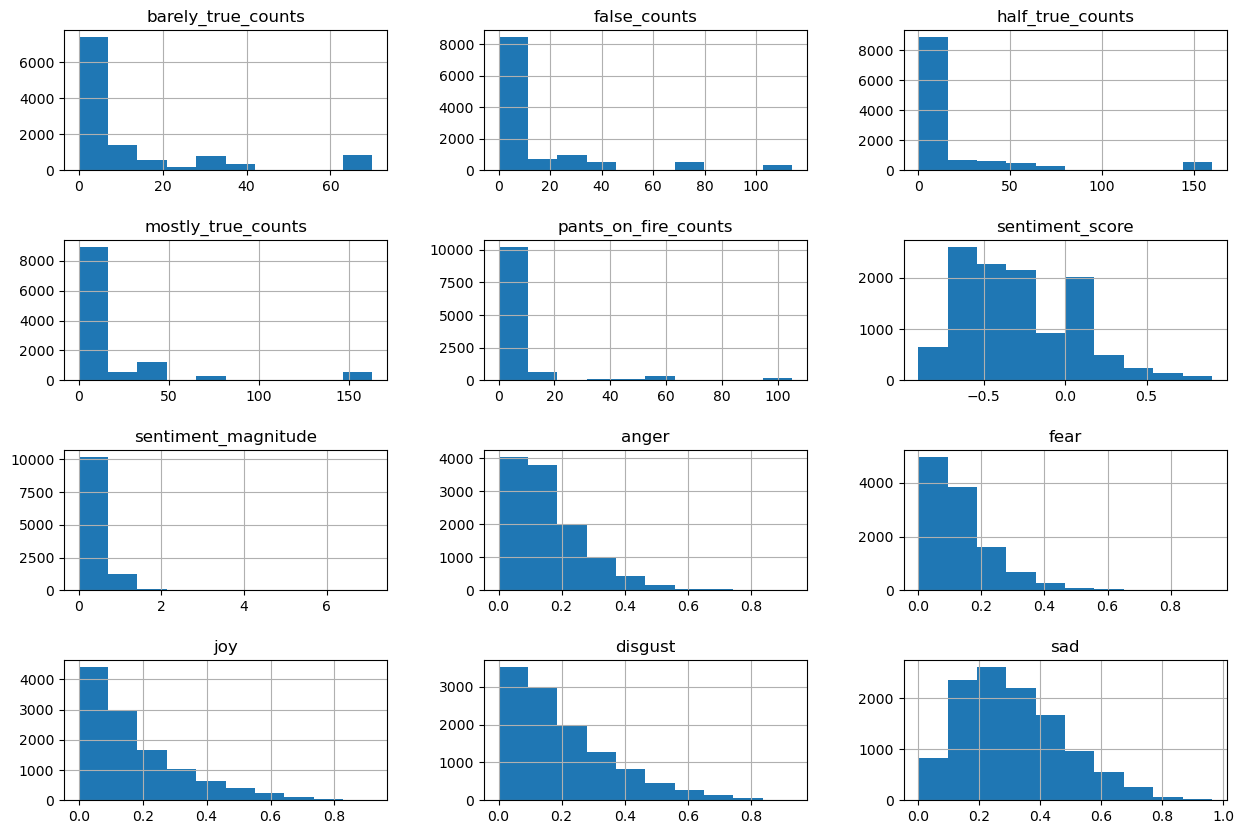

In [17]:
# We ploted all the numeric data to this what feild is usefull and which not. 
fake_news_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [18]:
fake_news_data['speaker_job'].value_counts()

speaker_job
President                                                                553
U.S. Senator                                                             540
Governor                                                                 432
President-Elect                                                          310
U.S. senator                                                             292
                                                                        ... 
artist                                                                     1
DeKalb County Chief Executive Officer                                      1
Human resources director                                                   1
managing partner at Nexus Homes                                            1
Director, Center for Higher Education, Texas Public Policy Foundation      1
Name: count, Length: 1269, dtype: int64

In [19]:
fake_news_data['statement'] = fake_news_data['statement'].str.lower()

In [20]:
# replace "pants-fire", "barely-true" to "false"
fake_news_data['label'] = fake_news_data['label'].replace(['pants-fire', 'barely-true'],'false')
fake_news_data['label'].value_counts()

label
false          5100
half-true      2361
mostly-true    2213
true           1845
Name: count, dtype: int64

In [21]:
# replace "half-true", "mostly-true" to "true"
fake_news_data['label'] = fake_news_data['label'].replace(['half-true', 'mostly-true'],'true')
fake_news_data['label'].value_counts()

label
true     6419
false    5100
Name: count, dtype: int64

In [22]:
fake_news_data[fake_news_data.duplicated()]
fake_news_data = fake_news_data.drop_duplicates()

In [23]:
fake_news_data['statement'] = fake_news_data['statement'].replace(r'[^\s\w0-9]', '', regex=True)

In [24]:
# some of the states had missed spelled state name or in different format so we change them to same.
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["District of Columbia", "Washington D.C.", "Washington, D.C.", "Washington DC"], "Washington D.C.")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Tex", "Texas"], "Texas")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Washington", "Washington state"], "Washington")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Virginia", "Virgina", "Virgiia"], "Virginia")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Pennsylvania", "PA - Pennsylvania"], "Pennsylvania")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Rhode Island", "Rhode island"], "Rhode Island")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Ohio", "ohio"], "Ohio")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Tennessee", "Tennesse"], "Tennessee")

In [25]:
us_state = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois',
            'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana',
            'Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon',
            'Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia',
            'Wisconsin','Wyoming','District of Columbia', 'Washington, D.C.']

fake_news_data = fake_news_data[fake_news_data['state_info'].isin(us_state)]

In [26]:
fake_news_scale = fake_news_data[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'sentiment_score', 'anger', 'fear', 'joy', 'disgust', 'sad']]

In [27]:
fake_scale = scale(fake_news_scale)

In [28]:
fake_news_scaled_df = pd.DataFrame(fake_scale, columns=fake_news_scale.columns)
fake_news_scaled_df.head()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,sentiment_score,anger,fear,joy,disgust,sad
0,-0.674013,-0.556981,-0.539551,-0.517016,-0.450707,-0.606948,-0.304710,-1.180478,-0.973070,0.422642,1.304971
1,-0.674013,-0.594711,-0.514468,-0.492173,-0.450707,-0.312807,-0.529394,-0.115020,0.089596,-1.128047,-1.261463
2,2.675746,2.084181,3.473780,3.532304,0.325759,-0.018665,-1.015561,-1.040100,2.076712,1.622708,-1.557559
3,0.043792,-0.255133,-0.037885,-0.045009,-0.278159,0.863759,-0.974798,0.727378,0.289223,-0.947656,-0.232733
4,-0.674013,-0.481519,-0.489385,-0.392803,-0.364433,-0.018665,-0.972210,-0.919577,0.754103,-1.008908,1.705506


In [29]:
fake_news_data['num_label'] = fake_news_data['label'].replace({'false' : 0, 'true' : 1})

C:\Users\17326\AppData\Local\Temp\ipykernel_21140\1966270977.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fake_news_data['num_label'] = fake_news_data['label'].replace({'false' : 0, 'true' : 1})


In [30]:
# Select features and target
X = fake_news_data['statement']
y = fake_news_data['num_label']

vectorization = CountVectorizer(min_df=60)
vectorization2 = TfidfVectorizer(min_df=60)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

xv_train2 = vectorization2.fit_transform(X_train)
xv_test2 = vectorization2.transform(X_test)

In [31]:
model = CatBoostClassifier(iterations = 1000, learning_rate = 0.2)
model.fit(xv_train, y_train) 

0:	learn: 0.6851836	total: 168ms	remaining: 2m 48s
1:	learn: 0.6797679	total: 196ms	remaining: 1m 37s
2:	learn: 0.6748251	total: 216ms	remaining: 1m 11s
3:	learn: 0.6713554	total: 230ms	remaining: 57.4s
4:	learn: 0.6687593	total: 245ms	remaining: 48.8s
5:	learn: 0.6664195	total: 259ms	remaining: 43s
6:	learn: 0.6650750	total: 274ms	remaining: 38.9s
7:	learn: 0.6634793	total: 290ms	remaining: 36s
8:	learn: 0.6613040	total: 306ms	remaining: 33.6s
9:	learn: 0.6596151	total: 321ms	remaining: 31.8s
10:	learn: 0.6572895	total: 335ms	remaining: 30.1s
11:	learn: 0.6558590	total: 349ms	remaining: 28.7s
12:	learn: 0.6544341	total: 361ms	remaining: 27.4s
13:	learn: 0.6534085	total: 370ms	remaining: 26.1s
14:	learn: 0.6521583	total: 380ms	remaining: 24.9s
15:	learn: 0.6507863	total: 388ms	remaining: 23.9s
16:	learn: 0.6492849	total: 397ms	remaining: 23s
17:	learn: 0.6479601	total: 404ms	remaining: 22s
18:	learn: 0.6466105	total: 410ms	remaining: 21.2s
19:	learn: 0.6448072	total: 416ms	remaining: 2

In [32]:
model.score(xv_test, y_test)

0.6181303116147309

In [33]:
#Make predictions
y_pred = model.predict(xv_test)

In [34]:
confusion_matrix(y_test, y_pred)

array([[372, 398],
       [276, 719]], dtype=int64)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.48      0.52       770
           1       0.64      0.72      0.68       995

    accuracy                           0.62      1765
   macro avg       0.61      0.60      0.60      1765
weighted avg       0.61      0.62      0.61      1765



In [36]:
model.fit(xv_train2, y_train) 

0:	learn: 0.6843354	total: 41.5ms	remaining: 41.4s
1:	learn: 0.6781509	total: 66.9ms	remaining: 33.4s
2:	learn: 0.6730860	total: 90.5ms	remaining: 30.1s
3:	learn: 0.6702497	total: 114ms	remaining: 28.5s
4:	learn: 0.6676587	total: 138ms	remaining: 27.4s
5:	learn: 0.6655611	total: 166ms	remaining: 27.6s
6:	learn: 0.6641644	total: 192ms	remaining: 27.3s
7:	learn: 0.6618385	total: 216ms	remaining: 26.7s
8:	learn: 0.6593620	total: 238ms	remaining: 26.2s
9:	learn: 0.6574418	total: 262ms	remaining: 25.9s
10:	learn: 0.6549506	total: 295ms	remaining: 26.5s
11:	learn: 0.6530750	total: 325ms	remaining: 26.7s
12:	learn: 0.6512881	total: 351ms	remaining: 26.7s
13:	learn: 0.6502098	total: 382ms	remaining: 26.9s
14:	learn: 0.6490102	total: 407ms	remaining: 26.7s
15:	learn: 0.6474597	total: 434ms	remaining: 26.7s
16:	learn: 0.6459317	total: 460ms	remaining: 26.6s
17:	learn: 0.6444063	total: 488ms	remaining: 26.6s
18:	learn: 0.6435941	total: 520ms	remaining: 26.8s
19:	learn: 0.6420250	total: 546ms	rema

In [37]:
model.score(xv_test2, y_test)

0.6045325779036828

In [38]:
model2 = LogisticRegression()
model2.fit(xv_train2, y_train)

y_pred2 = model2.predict(xv_test)

In [39]:
model2.score(xv_test, y_test)

0.5960339943342776

In [40]:
model2 = LogisticRegression()
model2.fit(xv_train2, y_train)
model2.score(xv_test2, y_test)

0.601699716713881

In [41]:
confusion_matrix(y_test, y_pred2)

array([[235, 535],
       [178, 817]], dtype=int64)

In [42]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.57      0.31      0.40       770
           1       0.60      0.82      0.70       995

    accuracy                           0.60      1765
   macro avg       0.59      0.56      0.55      1765
weighted avg       0.59      0.60      0.57      1765



In [43]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier()
model3.fit(xv_train, y_train)

RandomForestClassifier()

In [44]:
y_pred3 = model3.predict(xv_test)
model3.score(xv_test, y_test)

0.6158640226628895

In [45]:
model3 = RandomForestClassifier()
model3.fit(xv_train2, y_train)
model3.score(xv_test2, y_test)

0.6022662889518413

In [46]:
confusion_matrix(y_test, y_pred3)

array([[322, 448],
       [230, 765]], dtype=int64)

In [125]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.58      0.42      0.49       770
           1       0.63      0.77      0.69       995

    accuracy                           0.62      1765
   macro avg       0.61      0.59      0.59      1765
weighted avg       0.61      0.62      0.60      1765



In [47]:
# cross-validatation for CatBoost 
cv_results = cross_validate(model, xv_train2, y_train, cv=5)

0:	learn: 0.6835649	total: 33.1ms	remaining: 33.1s
1:	learn: 0.6771539	total: 60.6ms	remaining: 30.2s
2:	learn: 0.6727629	total: 85.5ms	remaining: 28.4s
3:	learn: 0.6694401	total: 109ms	remaining: 27.2s
4:	learn: 0.6666494	total: 134ms	remaining: 26.6s
5:	learn: 0.6640862	total: 158ms	remaining: 26.2s
6:	learn: 0.6609493	total: 189ms	remaining: 26.8s
7:	learn: 0.6598791	total: 217ms	remaining: 26.9s
8:	learn: 0.6581857	total: 245ms	remaining: 27s
9:	learn: 0.6561322	total: 274ms	remaining: 27.1s
10:	learn: 0.6542505	total: 303ms	remaining: 27.3s
11:	learn: 0.6514899	total: 329ms	remaining: 27.1s
12:	learn: 0.6495197	total: 356ms	remaining: 27s
13:	learn: 0.6474720	total: 388ms	remaining: 27.3s
14:	learn: 0.6462890	total: 416ms	remaining: 27.3s
15:	learn: 0.6449827	total: 443ms	remaining: 27.2s
16:	learn: 0.6436855	total: 473ms	remaining: 27.4s
17:	learn: 0.6429404	total: 506ms	remaining: 27.6s
18:	learn: 0.6414806	total: 535ms	remaining: 27.6s
19:	learn: 0.6401570	total: 564ms	remainin

In [48]:
cv_scores = cv_results['test_score']
cv_scores

array([0.57577904, 0.5694051 , 0.58215297, 0.5878187 , 0.59135977])

In [49]:
np.mean(cv_scores), np.std(cv_scores)

(0.5813031161473087, 0.007954742822718975)

In [50]:
# cross-validatation for LogisticRegression
cv_results = cross_validate(model2, xv_train2, y_train, cv=5)

In [51]:
cv_scores2 = cv_results['test_score']
cv_scores2

array([0.63172805, 0.60694051, 0.60835694, 0.61756374, 0.61402266])

In [52]:
np.mean(cv_scores2), np.std(cv_scores2)

(0.6157223796033995, 0.008875042604997488)

In [53]:
# cross-validatation for RandomForestClassifier
cv_results = cross_validate(model3, xv_train2, y_train, cv=5)

In [54]:
cv_scores3 = cv_results['test_score']
cv_scores3

array([0.5927762 , 0.60339943, 0.59490085, 0.60127479, 0.60835694])

In [55]:
np.mean(cv_scores3), np.std(cv_scores3)

(0.6001416430594901, 0.0056763356684175655)

In [56]:
# finding the best hyper parameters for LogisticRegression
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.01, 0.1, 1, 10],
              'max_iter': [100, 200, 500]}
    
grid_search = GridSearchCV(model2, param_grid=param_grid, cv=5)
grid_search.fit(xv_train2, y_train)

C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1194,

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [57]:
print(grid_search.best_params_)

{'C': 1, 'max_iter': 100, 'penalty': 'l2'}


In [58]:
lr_new = LogisticRegression(C = 1, max_iter = 100, penalty = 'l2')
lr_new.fit(xv_train2, y_train)
lr_new.score(xv_test2, y_test)

0.601699716713881

In [59]:
# finding the best hyper parameters for RandomForestClassifier
param_grid = {'n_estimators': [50, 100, 200],
              'bootstrap': [True, False]}

grid_search2 = GridSearchCV(estimator=model3, param_grid=param_grid, cv=5)
grid_search2.fit(xv_train2, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200]})

In [60]:
print(grid_search2.best_params_)

{'bootstrap': True, 'n_estimators': 200}


In [61]:
rf_new = RandomForestClassifier(bootstrap = True, n_estimators = 200)
rf_new.fit(xv_train2, y_train)

RandomForestClassifier(n_estimators=200)

In [62]:
y_pred4 = rf_new.predict(xv_test)
rf_new.score(xv_test2, y_test)

0.6101983002832861